In [1]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv

--2019-09-10 13:40:23--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.184.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.184.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2010492 (1.9M) [text/plain]
Saving to: ‘pollution.csv.3’

pollution.csv.3     100%[===================>]   1.92M  1.41MB/s    in 1.4s    

2019-09-10 13:40:25 (1.41 MB/s) - ‘pollution.csv.3’ saved [2010492/2010492]



In [37]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Model, Sequential
from keras.layers import Embedding, Input, Dense, LSTM

Using TensorFlow backend.


***Import and Transform data***

In [3]:
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

dataset = pd.read_csv('pollution.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)

# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'

# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)

# drop the first 24 hours
dataset = dataset[24:]

# summarize first 5 rows
print(dataset.head(5))

# save to file
dataset.to_csv('t-pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


***Plot numerical data***

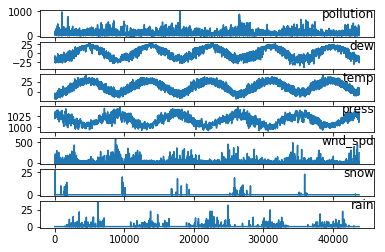

In [4]:
dataset = pd.read_csv('t-pollution.csv', header=0, index_col=0)

values = dataset.values
groups = [0, 1, 2, 3, 5, 6, 7]

i = 1
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
    
pyplot.show()

***Categorizing Wind Direction***

In [5]:
dataset["wnd_dir"].nunique()

4

In [6]:
dataset["wnd_dir"].value_counts()

SE    15290
NW    14130
cv     9384
NE     4996
Name: wnd_dir, dtype: int64

In [7]:
# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])

def categorize_wind(wind):
    if wind == 'SE':
        return 0
    if wind == 'NW':
        return 1
    if wind == 'NE':
        return 2
    return 3

dataset["wnd_dir"] = dataset["wnd_dir"].apply(categorize_wind)

# ensure all data is float
dataset["wnd_dir"] = dataset["wnd_dir"].astype('float32')

In [8]:
dataset["wnd_dir"].value_counts()

0.0    15290
1.0    14130
3.0     9384
2.0     4996
Name: wnd_dir, dtype: int64

In [9]:
# save to file
dataset.to_csv('te-pollution.csv')

***Convert Time Series to Supervised dataset***

In [31]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
dataset = pd.read_csv('te-pollution.csv', header=0, index_col=0)
values = dataset.iloc[:,[0, 1, 2, 3, 5, 6, 7]]
wnd_dir = dataset.iloc[:-1,[4]]
wnd_dir.reset_index(inplace=True)

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[8, 9,10,11,12,13]], axis=1, inplace=True)
reframed['var8(t-1)'] = wnd_dir["wnd_dir"]

print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.002290   0.000000   
2   0.148893   0.367647   0.245902   0.527273   0.003811   0.000000   
3   0.159960   0.426471   0.229508   0.545455   0.005332   0.000000   
4   0.182093   0.485294   0.229508   0.563636   0.008391   0.037037   
5   0.138833   0.485294   0.229508   0.563636   0.009912   0.074074   

   var7(t-1)   var1(t)  var8(t-1)  
1        0.0  0.148893        0.0  
2        0.0  0.159960        0.0  
3        0.0  0.182093        0.0  
4        0.0  0.138833        0.0  
5        0.0  0.109658        0.0  


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


***Split into Train and Test sets***

In [32]:
reframed.shape

(43799, 9)

In [35]:
values = reframed.values

n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, [0, 1, 2, 3, 4, 5, 6, 8]], train[:, [7]]
test_X, test_y = test[:, [0, 1, 2, 3, 4, 5, 6, 8]], test[:, [7]]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760, 1) (35039, 1, 8) (35039, 1)


***Build the model***

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 8760 samples, validate on 35039 samples
Epoch 1/50
 - 1s - loss: 0.0671 - val_loss: nan
Epoch 2/50
 - 0s - loss: 0.0494 - val_loss: nan
Epoch 3/50
 - 0s - loss: 0.0336 - val_loss: nan
Epoch 4/50
 - 0s - loss: 0.0202 - val_loss: nan
Epoch 5/50
 - 0s - loss: 0.0168 - val_loss: nan
Epoch 6/50
 - 0s - loss: 0.0158 - val_loss: nan
Epoch 7/50
 - 0s - loss: 0.0152 - val_loss: nan
Epoch 8/50
 - 0s - loss: 0.0150 - val_loss: nan
Epoch 9/50
 - 0s - loss: 0.0147 - val_loss: nan
Epoch 10/50
 - 0s - loss: 0.0147 - val_loss: nan
Epoch 11/50
 - 0s - loss: 0.0146 - val_loss: nan
Epoch 12/50
 - 0s - loss: 0.0145 - val_loss: nan
Epoch 13/50
 - 0s - loss: 0.0143 - val_loss: nan
Epoch 14/50
 - 0s - loss: 0.0145 - val_loss: nan
Epoch 15/50
 - 0s - loss: 0.0145 - val_loss: nan
Epoch 16/50
 - 0s - loss: 0.0146 - val_loss: nan
Epoch 17/50
 - 0s - loss: 0.0144 - val_loss: nan
Epoch 1

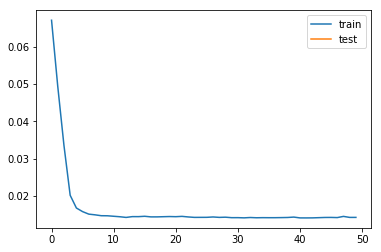

In [38]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

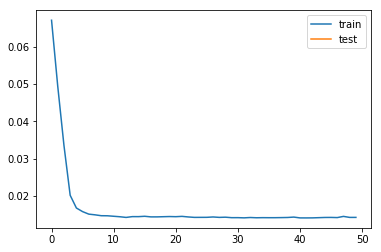

In [41]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

***Test***

In [42]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

ValueError: Error when checking input: expected lstm_1_input to have 3 dimensions, but got array with shape (35039, 8)